In [6]:
import keras

Using TensorFlow backend.


In [7]:
import tensorflow as tf

In [5]:
import numpy as np 
import pandas as pd
import scipy
#import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#!pip install pillow
#!pip install h5py


In [5]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


In [6]:
classes = ["adult_males", "subadult_males", "adult_females", "juveniles", "pups"]

file_names = os.listdir("C:/Users/pc-user/AppData/Local/Temp/TrainSmall2/Train")
file_names = sorted(file_names, key=lambda 
                    item: (int(item.partition('.')[0]) if item[0].isdigit() else float('inf'), item)) 

# select a subset of files to run on
file_names = file_names[0:1]

# dataframe to store results in
coordinates_df = pd.DataFrame(index=file_names, columns=classes)

In [7]:
coordinates_df

,adult_males,subadult_males,adult_females,juveniles,pups
41.jpg,NaN,NaN,NaN,NaN,NaN


In [8]:
from PIL import Image
import numpy as np
import skimage.color as sc

In [9]:
for filename in file_names:
    
    # read the Train and Train Dotted images
    image_1 = cv2.imread("C:/Users/pc-user/AppData/Local/Temp/TrainSmall2/TrainDotted/" + filename)
    image_2 = cv2.imread("C:/Users/pc-user/AppData/Local/Temp/TrainSmall2/Train/" + filename)
    
    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)
    
    # mask out blackened regions from Train Dotted
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 20] = 0
    mask_1[mask_1 > 0] = 255
    
    mask_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    mask_2[mask_2 < 20] = 0
    mask_2[mask_2 > 0] = 255
    
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
    image_3 = cv2.bitwise_or(image_3, image_3, mask=mask_2) 
    
    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)
    
    # detect blobs
    blobs = skimage.feature.blob_log(image_3, min_sigma=3, max_sigma=4, num_sigma=1, threshold=0.02)
    
    adult_males = []
    subadult_males = []
    pups = []
    juveniles = []
    adult_females = [] 
    
    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        g,b,r = image_1[int(y)][int(x)][:]
        
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if r > 200 and g < 50 and b < 50: # RED
            adult_males.append((int(x),int(y)))        
        elif r > 200 and g > 200 and b < 50: # MAGENTA
            subadult_males.append((int(x),int(y)))         
        elif r < 100 and g < 100 and 150 < b < 200: # GREEN
            pups.append((int(x),int(y)))
        elif r < 100 and  100 < g and b < 100: # BLUE
            juveniles.append((int(x),int(y))) 
        elif r < 150 and g < 50 and b < 100:  # BROWN
            adult_females.append((int(x),int(y)))
            
    coordinates_df["adult_males"][filename] = adult_males
    coordinates_df["subadult_males"][filename] = subadult_males
    coordinates_df["adult_females"][filename] = adult_females
    coordinates_df["juveniles"][filename] = juveniles
    coordinates_df["pups"][filename] = pups

In [10]:
coordinates_df

,adult_males,subadult_males,adult_females,juveniles,pups
41.jpg,"[(2749, 2516), (3110, 2349), (2293, 2315), (25...",[],"[(2960, 2561), (3049, 2550), (2981, 2536), (30...","[(2922, 2514), (3081, 2421), (3015, 2240), (29...","[(2977, 2576), (2833, 2530), (2913, 2520), (29..."


# Extract 32 by 32 images

In [11]:
x = []
y = []

for filename in file_names:    
    image = cv2.imread("C:/Users/pc-user/AppData/Local/Temp/TrainSmall2/Train/" + filename)
    for lion_class in classes:
        for coordinates in coordinates_df[lion_class][filename]:
            thumb = image[coordinates[1]-16:coordinates[1]+16,coordinates[0]-16:coordinates[0]+16,:]
            if np.shape(thumb) == (32, 32, 3):
                x.append(thumb)
                y.append(lion_class)
x = np.array(x)
y = np.array(y)

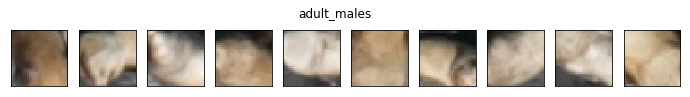

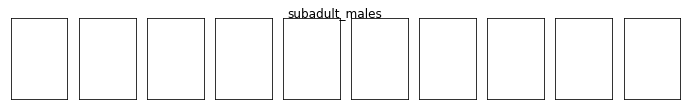

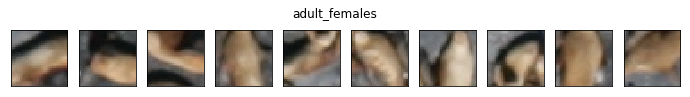

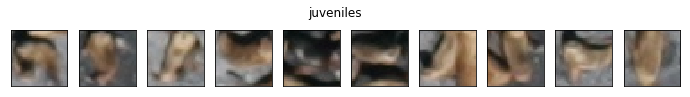

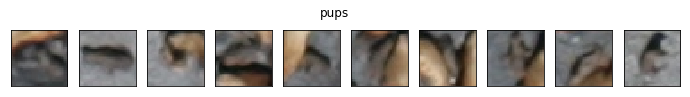

In [12]:
for lion_class in classes:
    f, ax = plt.subplots(1,10,figsize=(12,1.5))
    f.suptitle(lion_class)
    axes = ax.flatten()
    j = 0
    for a in axes:
        a.set_xticks([])
        a.set_yticks([])
        for i in range(j,len(x)):
            if y[i] == lion_class:
                j = i+1
                a.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
                break

# One hot encoding

In [13]:
encoder = LabelBinarizer()
encoder.fit(y)
y = encoder.transform(y).astype(float)

# Build Keras model

In [14]:
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(32,32,3)))


model.add(Conv2D(32, (4, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (4, 4), activation='relu', padding='same'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(x[:10], y[:10], epochs=2, validation_split=0.2, verbose=0)

In [1]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
